In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd

import sys
sys.path.append('../../tools')
from dust_extinction import calALambda
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

z = 0.016268
t_max = 2457689.98
t_max_mjd = t_max - 2400000.5
ebv = 0.026
rv = 3.1

In [10]:
color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [11]:
import glob

spec_files_0 = glob.glob('../../spectroscopy/SN2016hnk/*dat')
spec_files_0.sort()
spec_files = [s for s in spec_files_0 if (('NTT' in s) or ('NOT' in s)) and not (('Flamingos' in s) or ('Sofi' in s))]
spec_He_files = [s for s in spec_files_0 if (('Flamingos' in s) or ('Sofi' in s))]

# Compare Lines

In [12]:
def velocity_rf(lambda_rf, lambda_0):
    '''convert rest-frame wavelength to relative velocity'''
    c = 2.99792458e5
    v = c * ((lambda_rf / lambda_0)**2 - 1) / ((lambda_rf / lambda_0)**2 + 1)

    return v

In [59]:
def compare_lines(spec_files,
                  ax,
                  line=10830,
                  vmax=-30000,
                  vmin=0,
                  norm_fac=1,
                  bin_size=100,
                  phase_min=-np.inf,
                  phase_max=np.inf,
                  col=[],
                  instru=[]):
    '''Compare the line regions in velocity space
    '''

    from data_binning import data_binning, plot_box_spec
    from astropy.time import Time

    spec_num = -1
    for spec in spec_files:
        if 'P60' in spec:
            continue
        with open(spec) as f:
            ll = f.readlines()
        # brute force
        mjd_found = False
        #print('Warning: MJD-obs not found in {}!'.format(spec))
        #print('Try the observation date.')
        year = '2016hnk_'
        pos_dat = spec.find(str(year)) + len(year)
        year_obs = spec[pos_dat:pos_dat + 4]
        mon_obs = spec[pos_dat + 5:pos_dat + 7]
        date_obs = spec[pos_dat + 8:pos_dat + 10]
        mjd_obs = Time('{}-{}-{}'.format(year_obs, mon_obs, date_obs)).mjd
        phase = (mjd_obs - t_max_mjd) / (1 + z)
        if (phase < phase_min) or (phase > phase_max):
            continue
        print(spec)
        spec_num += 1
        spec_df = pd.read_csv(spec,
                              comment='#',
                              delim_whitespace=True,
                              header=None)

        wv0, fl0 = spec_df[0].values / (1 + z), spec_df[1].values
        try:
            fl_unc0 = spec_df[2].values
        except:
            fl_unc0 = np.ones_like(wv0)
        E0 = 10**(0.4 * calALambda(wv0, rv, ebv))
        norm = np.nanmedian(fl0[np.abs(wv0 - 8500) < 2500])
        fl0 *= E0 / norm
        fl_unc0 *= E0 / norm
        wv0, fl_unc0 = wv0[~np.isnan(fl0)], fl_unc0[~np.isnan(fl0)]
        fl0 = fl0[~np.isnan(fl0)]
        vel_rf0 = velocity_rf(wv0, line)

        out = data_binning(np.array([vel_rf0, fl0, fl_unc0]).T, size=bin_size)
        vel_rf_bin, fl_bin = plot_box_spec(out[:, 0], out[:, 1])
        vel_rf, fl = plot_box_spec(vel_rf0, fl0)

        if len(col) == 0:
            col = np.repeat([None], len(spec_files))

        if phase < 0:
            label = r'$-{:.0f}\,\mathrm d$'.format(np.abs(phase))
        else:
            label = r'$+{:.0f}\,\mathrm d$'.format(np.abs(phase))
        print(phase)

        h = 0.5 * (phase / 3)**.2
        ax.plot(vel_rf_bin[(vel_rf_bin < vmin) & (vel_rf_bin > vmax)] / 1000,
                np.log10(fl_bin[(vel_rf_bin < vmin) & (vel_rf_bin > vmax)]) -
                spec_num * h * norm_fac,
                color=col[spec_num],
                linewidth=1.5)
        ax.plot(vel_rf[(vel_rf < vmin) & (vel_rf > vmax)] / 1000,
                np.log10(fl[(vel_rf < vmin) & (vel_rf > vmax)]) -
                spec_num * h * norm_fac,
                alpha=0.2,
                color=col[spec_num])
        vm = vel_rf[(vel_rf < vmin) & (vel_rf > vmax)][-1]
        arg = np.abs(vel_rf_bin - vmin + (vmin - vmax) * 0.8) < 5000
        if arg.sum() == 0:
            arg = [3, 4]
        ax.text(vmax / 1000,
                np.log10(np.median(fl_bin[arg])) -
                spec_num * h * norm_fac - 0.15 * h,
                label,
                color=col[spec_num],
                va='top',
                ha='left')
        ax.text((vm - (vm - vmax) * 0.12) / 1000,
                np.log10(fl[np.argmin(np.abs(vel_rf - vmin))]) -
                (spec_num + 0.3) * h * norm_fac,
                '${}$'.format(instru[spec_num]),
                color=col[spec_num],
                va='center')
        ax.set_xlim((vmax - (vmin - vmax) * 0.05) / 1000,
                    (vmin + (vmin - vmax) * 0.2) / 1000)
        ax.set_ylabel(r'$\log F_\lambda+ \mathrm{offset}$')
        #plt.fill_between(vel_rf,
        #                 fl - fl_unc, fl + fl_unc,
        #                 alpha=0.5, color=col[k + displace])
    ax.set_xlabel('$v\ [10^3\ \mathrm{km\,s}^{-1}]$')
    #ax.set_yticks([])

../../spectroscopy/SN2016hnk/2016hnk_2016-11-05_01-59-35.148_ESO-NTT_EFOSC2-NTT_PESSTO.dat
7.399622934126261
../../spectroscopy/SN2016hnk/2016hnk_2016-11-07_00-05-48.541_NOT_ALFOSC_PESSTO.dat
9.367607757027306
../../spectroscopy/SN2016hnk/2016hnk_2016-11-07_02-06-58.316_ESO-NTT_EFOSC2-NTT_PESSTO.dat
9.367607757027306
../../spectroscopy/SN2016hnk/2016hnk_2016-11-04_01-57-23.700_Gemini-S_Flamingos-2_PESSTO.dat
6.4156305226757375
../../spectroscopy/SN2016hnk/2016hnk_2016-11-06_02-05-03.429_ESO-NTT_Sofi_PESSTO.dat
8.383615345576784


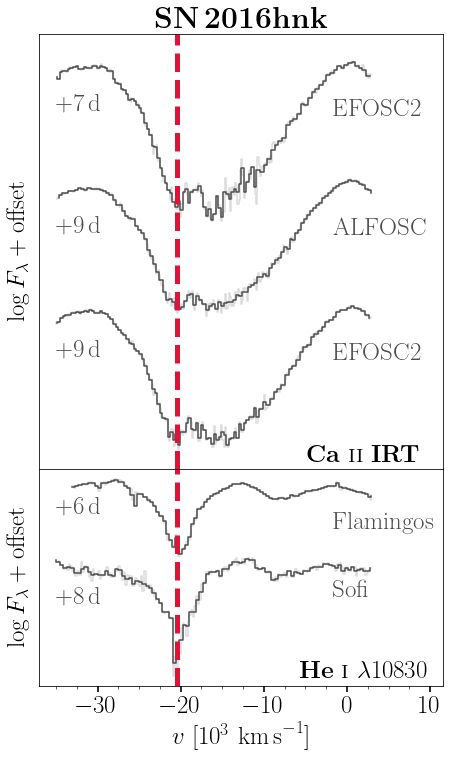

In [60]:
fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec(nrows=3,
                      ncols=3,
                      left=0.05,
                      right=0.75,
                      hspace=0,
                      wspace=0.05)
ax0 = fig.add_subplot(gs[:-1, :])
ax1 = fig.add_subplot(gs[-1, :])

Ca_II_IRT = (8498.018 + 8542.089 + 8662.140) / 3
col_Ca = ['0.3', '0.3', '0.3']
instru = [
    r'\mathrm{EFOSC2}', r'\mathrm{ALFOSC}', r'\mathrm{EFOSC2}'
]
compare_lines(spec_files,
              ax0,
              line=Ca_II_IRT,
              vmax=-35000,
              vmin=3000,
              phase_min=5,
              phase_max=10,
              norm_fac=1.7,
              bin_size=300,
              col=col_Ca,
              instru=instru)
#ax0.set_ylim(-1.7, 0.5)
ax0.set_xticks([])
ax0.set_xlabel('')
ax0.set_yticks([-1.5, -1, -0.5, 0, 0.5])
ax0.text(2, -3.24, r'$\mathbf{Ca\ \textsc{ii}\ IRT}$', ha='center')

HeI = 10830
col_He = ['0.3', '0.3']
instru_He = [r'\mathrm{Flamingos}', r'\mathrm{Sofi}']
compare_lines(spec_He_files,
              ax1,
              line=HeI,
              vmax=-35000,
              vmin=3000,
              phase_min=3,
              phase_max=9,
              norm_fac=1,
              bin_size=300,
              col=col_He,
              instru=instru_He)
#ax1.set_ylim(-1.2, 0.4)
ax0.set_yticks([])
ax1.set_yticks([])
ax1.text(2, -1.48, r'$\mathbf{He\ \textsc{i}}\ \mathrm{\lambda 10830}$', ha='center')

ax0.set_xlim(-37, 11.5)
ax1.set_xlim(-37, 11.5)

ax0.axvline(-20.5, color='crimson', linestyle='--', linewidth=5)
ax1.axvline(-20.5, color='crimson', linestyle='--', linewidth=5)
ax1.xaxis.set_minor_locator(MultipleLocator(2.5))
ax1.xaxis.set_major_locator(MultipleLocator(10))

ax0.set_title('$\mathbf{SN\,2016hnk}$')
plt.savefig('CaII_HeI_hvf.pdf', bbox_inches='tight')